In [1]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import Counter 
from matplotlib.colors import ListedColormap
import json
import folium
%matplotlib inline
pth = r"C:\EPFL\2018-2019\nltk_data" #change location according to your nltk data path
nltk.data.path.append(pth)
sns.set()

C:\Anaconda\envs\ada\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.24) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stopwords = ''
with open('stopw.txt') as f:
        # return the split results, which is all the words in the file.
        stopwords = f.read().split()

### helper functions

In [3]:
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()

def tokenization(t) : 
    return tokenizer.tokenize(t)

def remove_all(to_filter, seq) :
    l = list(filter(lambda x : x not in seq, to_filter))
    l = list(filter(lambda x : not x.isdigit(), l))
    l = ['lol' if x=='ll' else x for x in l] 
    return l

def to_string(l) :
    s = ''
    for x in l :
        s += x + ' '
    return s

def word_freq_in_tweet(tw) :
    tweet = to_string(tw)
    return Counter(tweet.split())

### Import datasets

In [4]:
data_folder = 'twitter-datasets'

In [5]:
train_pos = pd.read_table(data_folder + '/train_pos.txt', header =None, names=['text'], sep='\n')
train_pos['label'] = 'positive'
train_neg = pd.read_table(data_folder + '/train_neg.txt', header =None, names=['text'], sep='\n')
train_neg['label'] = 'negative'

In [6]:
print('There are {} positive tweets and {} negative tweets'.format(train_pos.shape[0], train_neg.shape[0]))

There are 97718 positive tweets and 98954 negative tweets


**Preprocessing : create an unbiased tweets dataset, split tweets in list of words, remove stopwords and lemmatize**

In [7]:
t = pd.concat([train_neg, train_pos]) #merge positive and negative tweets
t = t.sample(frac=1).reset_index(drop=True) #shuffle the datas
t = pd.DataFrame(t.apply(lambda row : pd.Series([tokenization(row[0]), row[1]]), axis=1)) #split tweets in list of words
t = pd.DataFrame(t.apply(lambda row : pd.Series([remove_all(row[0], stopwords), row[1]]), axis=1)) #remove stopwords
t = pd.DataFrame(t.apply(lambda row : pd.Series([[wordnet_lemmatizer.lemmatize(x) for x in row[0]], row[1]]), axis=1)) #lemmatize
t.head()

,0,1
0,"[hello, lou, can, please, follow, xx]",positive
1,"[whattt, don, love, ooo, young]",positive
2,"[yonex, rqis, tour, xl, tennis, racquet, ana, ...",negative
3,"[can, wait, info, teaming, partner, health, bu...",positive
4,"[true, haha, thank]",positive


In [8]:
t.columns = ['text', 'labels']

### Fixed variables

In [9]:
N = t.shape[0]

## Feature engineering

**From attributes to features**

1) Get frequencies of words in each twet

In [10]:
t['tweet_Freq'] = t.apply(lambda row : pd.Series([word_freq_in_tweet(row[0])]), axis=1)

In [11]:
t.head()

,text,labels,tweet_Freq
0,"[hello, lou, can, please, follow, xx]",positive,"{'hello': 1, 'lou': 1, 'can': 1, 'please': 1, ..."
1,"[whattt, don, love, ooo, young]",positive,"{'whattt': 1, 'don': 1, 'love': 1, 'ooo': 1, '..."
2,"[yonex, rqis, tour, xl, tennis, racquet, ana, ...",negative,"{'yonex': 1, 'rqis': 2, 'tour': 2, 'xl': 2, 't..."
3,"[can, wait, info, teaming, partner, health, bu...",positive,"{'can': 1, 'wait': 1, 'info': 1, 'teaming': 1,..."
4,"[true, haha, thank]",positive,"{'true': 1, 'haha': 1, 'thank': 1}"


2) Get frequencies of words in all corpus

In [12]:
corpus = ''
for i in range(N) :
    tw = t.iloc[i, 0]
    corpus += to_string(tw)
    
corpus = Counter(corpus.split())
d_corpus = pd.DataFrame(list(corpus.items()), columns=['word', 'occurences'])
d_corpus = d_corpus.sort_values(by='occurences', ascending=False)

Look distribution of words occurences and get top 25 words

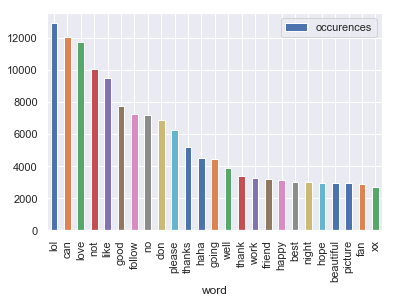

In [13]:
top25 = d_corpus.head(25)
top25.plot(kind='bar', x='word', y='occurences')

In [14]:
tweets = t[['labels', 'tweet_Freq']]
tweets.head()

,labels,tweet_Freq
0,positive,"{'hello': 1, 'lou': 1, 'can': 1, 'please': 1, ..."
1,positive,"{'whattt': 1, 'don': 1, 'love': 1, 'ooo': 1, '..."
2,negative,"{'yonex': 1, 'rqis': 2, 'tour': 2, 'xl': 2, 't..."
3,positive,"{'can': 1, 'wait': 1, 'info': 1, 'teaming': 1,..."
4,positive,"{'true': 1, 'haha': 1, 'thank': 1}"


**Feature Creation Strategy**

We don't need to high freq n-grams and low-freq n-grams (stop-words and typos), otherwise we will overfit.
Hence keep medium frequency n-grams. which one are good ?
The n-gram with smaller freq can be more discriminating bc it can capture a specific issue in the tweet. 

In order to capture this idea, we will use TF-IDF
 
TERM FREQUENCY (tf)
tf(t, d) : token freq in tweet d
Use either term freq : f(t, d) / sum(f(t', d)) OR log normalization 1 + log(f(t, d)) with f(t,d) being the raw count of t in d.


INVERSE DOCUMENT FREQUENCY (IDF)
idf(t, D) = log(N / number of docs (tweets for us) where t appears) with N = number of docs in corpus (number of tweets ) 

TF-IDF VALUE
tfidf(t, d, D) = tf(t, d) * idf(t, D)
high weight is reached by high term freq and low doc freq of the term in whole corpus.
IDEA : find frequent terms in tweets that are not so frequent in whole data set.
So replace counters with TF-IDF and normalize results row-wise (divide by L2 norm)


**Helper Functions**

In [15]:
def raw_freq(word, tweet_f) :
    r = tweet_f.get(word)
    return 0 if r == None else r
    

def term_frequency(t, d) : 
    return np.log(1 + raw_freq(t, d))

term_doc_occurences = {}

def inverse_doc_frequency(t, df) :
    number_of_docs = df.shape[0] #number of tweets in corpus 
    count = 0 #count number of tweets where t appears
    
    v = term_doc_occurences.get(t) #lookup in database
    
    if(v == None) : #if this term is not yet registered in database
        for i in range(N) :
            count += 1 if (raw_freq(t, df.iloc[i, 1]) > 0) else 0
        term_doc_occurences[t] = count #update database
    else :
        count = v       
        
    return np.log(number_of_docs/count)

def tf_idf(t, d, df) :
    return term_frequency(t, d) * inverse_doc_frequency(t, df)

**Next we will create a dataframe with 25 features representing the tf-idf value of the top 25 words computed earlier**

In [16]:
training_data = tweets[['labels']]
to_be_features = list((top25.T).values[0]) 

In [17]:
for ft in to_be_features : #for each feature
    col = []
    for i in range(tweets.shape[0]) : #for each row compute tdf-if value
        tfidf = tf_idf(ft, tweets.iloc[i, 1], tweets)
        col.append(tfidf)
    training_data[ft] = pd.Series(col)

In [18]:
training_data.head()

,labels,lol,can,love,not,like,good,follow,no,don,...,work,friend,happy,best,night,hope,beautiful,picture,fan,xx
0,positive,0.0,1.970392,0.000000,0.0,0.0,0.0,2.378759,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.978861
1,positive,0.0,0.000000,2.002453,0.0,0.0,0.0,0.000000,0.0,2.358984,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,negative,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,positive,0.0,1.970392,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,positive,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


**Finally, we normalize row-wise by L2-norm, encode labels to (positive :+1 and negative :-1) and we have a dataset ready for logistic regression**

Encode labels

In [19]:
training_data['labels'] = training_data.apply(lambda row : pd.Series([1.0 if row[0] == 'positive' else -1.0]), axis=1)

In [20]:
training_data.head()

,labels,lol,can,love,not,like,good,follow,no,don,...,work,friend,happy,best,night,hope,beautiful,picture,fan,xx
0,1.0,0.0,1.970392,0.000000,0.0,0.0,0.0,2.378759,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.978861
1,1.0,0.0,0.000000,2.002453,0.0,0.0,0.0,0.000000,0.0,2.358984,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,-1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,1.0,0.0,1.970392,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


Normalize rows

In [21]:
def normalize(row) :
        vec_norm = np.sqrt(np.sum([x*x for x in row]))
        return [0 if vec_norm == 0 else (x / vec_norm) for x in row ]

In [22]:
training_data = training_data.apply(lambda row : pd.Series([row[0]] + normalize(row[1:])), axis=1)

In [23]:
training_data.columns = ['label'] + to_be_features

In [24]:
training_data.head()

,label,lol,can,love,not,like,good,follow,no,don,...,work,friend,happy,best,night,hope,beautiful,picture,fan,xx
0,1.0,0.0,0.398158,0.000000,0.0,0.0,0.0,0.480677,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.60194
1,1.0,0.0,0.000000,0.647145,0.0,0.0,0.0,0.000000,0.0,0.762367,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
2,-1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
3,1.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
4,1.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000


In [25]:
training_data.shape

(196672, 26)

 **Our data set is finally ready. Its sample size is 196672 and contains 25 features with the predicted variable (label). Let's save this in a npy file, in order to save us from computation time at each load**

In [26]:
training_data.to_pickle('training_data')